In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.tree_util import Partial

import jaxkd as jk
import hugegp as hg

import matplotlib.pyplot as plt

key = jr.key(99)

In [139]:
covariance = hg.matern_cov_discretized(1e-4, 10, 300, eps=1e-4)

# Manual refinement

In [303]:
points = jnp.mgrid[-3:3:40j, -3:3:40j].reshape(2, -1).T
n_points = len(points)

graph = hg.build_lazy_graph(points, n_initial=100, k=4)
points, neighbors, offsets, indices = graph

In [304]:
key, k1 = jr.split(key)
xi = jr.normal(k1, (10000, n_points))

values = jax.vmap(Partial(hg.generate, graph, covariance, cuda=True))(xi)[:, graph[3]]
variance = jnp.var(values, axis=0)

In [305]:
neigh = jnp.concatenate((neighbors[321], jnp.array([321])))

In [344]:
neigh = neighbors[400]
neigh

Array([ 48, 144, 208, 304], dtype=uint32)

In [346]:
neighbors[jnp.array([204, 304])]

Array([[ 28,  44,  76, 156],
       [ 16,  48, 112, 176]], dtype=uint32)

In [339]:
neigh = jnp.array([101, 369])

In [340]:
cov_ideal = hg.covariance.cov_lookup_matrix(points[neigh], points[neigh], *covariance)
cov_ideal

Array([[1.0001    , 0.01806445],
       [0.01806445, 1.0001    ]], dtype=float32)

In [341]:
cov_true = jnp.cov(values[:,neigh], rowvar=False)
cov_true

Array([[1.025792  , 0.00931668],
       [0.00931668, 1.0012819 ]], dtype=float32)

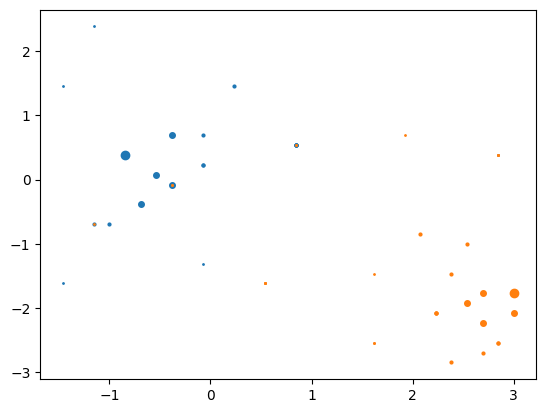

In [309]:
plt.scatter(*points[jnp.array([133])].T, c='C0')
plt.scatter(*points[neighbors[133]].T, s=16, c='C0')
plt.scatter(*points[neighbors[neighbors[133]]].reshape(-1,2).T, s=4, c='C0')
plt.scatter(*points[neighbors[neighbors[neighbors[133]]]].reshape(-1,2).T, s=1, c='C0')

plt.scatter(*points[jnp.array([216])].T, c='C1')
plt.scatter(*points[neighbors[216]].T, s=16, c='C1')
plt.scatter(*points[neighbors[neighbors[216]]].reshape(-1,2).T, s=4, c='C1')
plt.scatter(*points[neighbors[neighbors[neighbors[216]]]].reshape(-1,2).T, s=1, c='C1')

# plt.scatter(*points[neighbors[216]].T, s=8)
# plt.scatter(*points[321].T)
plt.show()

In [258]:
jnp.linalg.solve(cov_true, jnp.array([1,1]))

Array([0.94945633, 0.98649794], dtype=float32)

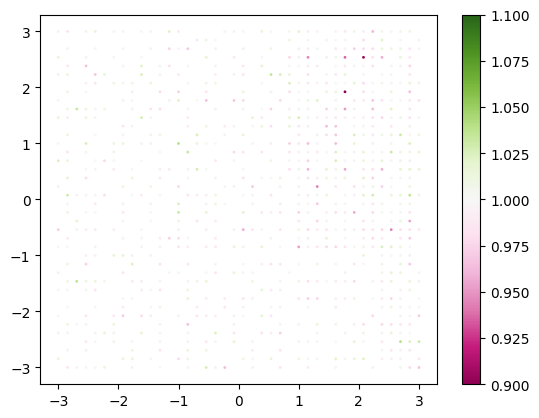

In [316]:
end = graph[2][3]
plt.scatter(*graph[0][:end].T, c=variance[:end], cmap='PiYG', vmin=0.9, vmax=1.1, s=1)
plt.colorbar()
plt.show()

In [ ]:
def refine(graph, covariance, xi):
    points, neighbors, offsets, indices = graph
    cov_bins, cov_vals = covariance

    initial_cov = hg.covariance.cov_lookup_matrix(points[: offsets[0]], points[: offsets[0]], cov_bins, cov_vals)
    initial_cholesky = jnp.linalg.cholesky(initial_cov)

    initial_values = initial_cholesky @ xi[: offsets[0]]
    values = [initial_values]
    matrices = []
    offsets = offsets + (len(points),)

    for i in range(len(offsets) - 1):
        start = offsets[i]
        end = offsets[i + 1]

        fine_point = points[start:end][:, jnp.newaxis]
        fine_xi = xi[start:end]
        coarse_points = points[neighbors[start:end]]
        coarse_values = jnp.concatenate(values)[neighbors[start:end]]

        Kff = hg.covariance.cov_lookup(jnp.array([0.0]), cov_bins, cov_vals)
        Kcc = hg.covariance.cov_lookup_matrix(coarse_points, coarse_points, cov_bins, cov_vals)
        Kfc = hg.covariance.cov_lookup_matrix(fine_point, coarse_points, cov_bins, cov_vals).squeeze(-2)

        mean = Kfc * jnp.linalg.solve(Kcc, coarse_values[..., jnp.newaxis]).squeeze(-1)
        mean = jnp.sum(mean, axis=-1)

        var = Kff - jnp.sum(Kfc * jnp.linalg.solve(Kcc, Kfc[..., jnp.newaxis]).squeeze(-1), axis=-1)
        std = jnp.sqrt(var)
        values.append(mean + std * fine_xi)
        matrices.append((Kcc, Kfc, Kff))

    return values, matrices

In [ ]:
values, matrices = jax.vmap(Partial(refine, graph, covariance))(xi)
variance = jnp.var(values, axis=0)